# Filtrado del Dataset

## Importación de librerías y datos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime

In [2]:
df = pd.read_csv('../Datasets/Dataset_1.csv',index_col='fecha')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

## Eliminación de los valores de 2022

Eliminamos el rango temporal de 2022, dado que hay un aumento de la anomalía de mala asignación de curvas. Realizamos este paso aquí para poder también observar el cambio de proporciones, justificando la eliminación.

Ahora nos quedamos con dos dataframes:

df <- dataframe de trabajo, con los datos de 2021

df2022 <- dataframe solo con los datos de 2022, para observar las proporciones de anomalías

In [3]:
df2022 = df[(df.index > '2022-01-01 00:00:00') & (df.index < '2023-01-01 00:00:00')]
df = df.drop(df[df.index>'2022'].index)

## Eliminación de parada de planta

Si el dataset contiene la parada de agosto de 2021, se eliminan esos registros. Además, se elimina hasta el 22 de septiembre por contener mala información.

(El parón está localizado entre el 16/08/21 y 04/09/21 + mala información hasta 22 de septiembre)

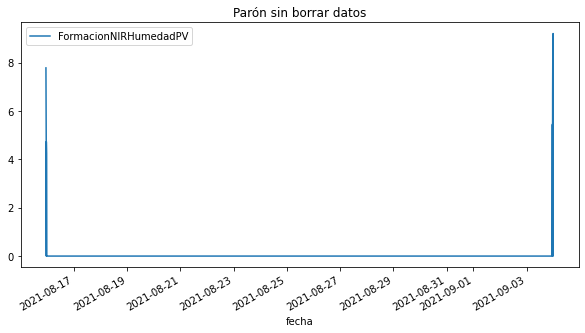

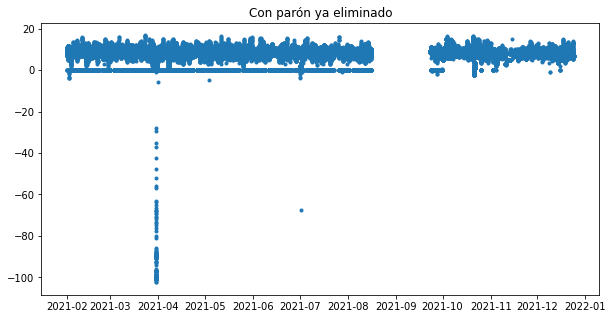

In [4]:
if (any((df.index > '2021-08-15 23:00:00') & (df.index < '2021-09-4 00:00:00'))):
    date_form = DateFormatter("%d-%b")
    df[(df.index > '2021-08-15 23:00:00') & (df.index < '2021-09-4 00:00:00')]['FormacionNIRHumedadPV'].plot(
    figsize=(10,5),legend=True)
    plt.title('Parón sin borrar datos')
    plt.show()

    df = df.drop(df[(df.index > '2021-08-15 23:00:00') & (df.index < '2021-09-23 01:00:00')].index)

    plt.figure(figsize=(10, 5))
    plt.plot(df.index,df.FormacionNIRHumedadPV,".")
    plt.title('Con parón ya eliminado')
    plt.show()
else:
    print('No hay valores en el rango del parón')

## Eliminación de cambios

Eliminamos 1min antes y después de los cambios de espesor, y 5min antes y después de los cambios de producto.

Para ello, utilizo los índices en los cuales 'ComisionActualNetoEspesor' o 'ComisionActualProductoCodigo' es mayor de uno, como se explicó durante la agregación del datset.

Primero guardo los índices (=fechas), después, elimino el rango de índices (=fechas) de cada cambio en un intervalo determinado.

### Espesor:

In [5]:
print('Cambios de espesor: ', df[df['ComisionActualNetoEspesor']>1]['ComisionActualNetoEspesor'].count())

Cambios de espesor:  1969


In [6]:
print('Filas antes de borrar: ',len(df))

Filas antes de borrar:  400489


In [7]:
cambios_espesor = df[df['ComisionActualNetoEspesor']>1].index
minutos_borrado_espesor = 1
for cambio in cambios_espesor:
    df = df.drop(df.loc[(cambio-datetime.timedelta(minutes=minutos_borrado_espesor)):(cambio+datetime.timedelta(minutes=minutos_borrado_espesor)),].index)

In [8]:
print('Filas después de borrar: ',len(df))

Filas después de borrar:  394591


### Producto:

In [9]:
print('Cambios de producto: ', df[df['ComisionActualProductoCodigo']>1]['ComisionActualProductoCodigo'].count())

Cambios de producto:  514


In [10]:
print('Filas antes de borrar: ',len(df))

Filas antes de borrar:  394591


In [11]:
cambios_producto = df[df['ComisionActualProductoCodigo']>1].index
minutos_borrado_producto = 5
for cambio in cambios_producto:
    df = df.drop(df.loc[(cambio-datetime.timedelta(minutes=minutos_borrado_producto)):(cambio+datetime.timedelta(minutes=minutos_borrado_producto)),].index)

In [12]:
print('Filas después de borrar: ',len(df))

Filas después de borrar:  388940


### Eliminamos ComisionActualProductoCodigo y ComisionActualNetoEspesor por no ser ya de utilidad:

In [13]:
df = df.drop(['ComisionActualProductoCodigo', 'ComisionActualNetoEspesor'], axis=1)

## Eliminamos registros de planta parada

Eliminamos aquellos registros donde la planta está parada (ExtractorVelocidadPV <20).

In [14]:
planta_parada = df[df['ExtractorVelocidadPV'] < 20].index
df = df.drop(planta_parada)

## Eliminación de outliers

Dado que puede haber valores realmente anómalos y absurdos (como puede ser 10^15), eliminamos los valores fuera del rango intercuartílico 0.01-0.99.
Para eso, primero almaceno los límites de cada cuantil a eliminar con df.quantile(valor), y después elimino los que se encuentren fuera.

Describe antes de la eliminación de outliers:

In [15]:
df.describe()

,FormacionNIRHumedadPV,FibraticPredNIRHumedadPV,Hum_Pred,Etapa2MWHumedadPV,ExtractorVelocidadPV,FormacionAlturaMantaPV,FormadoraVelocidadPV,FormadoraSiloNivel,SiloFibraNivel,SiloFibraVelocidadPV,...,ScalperReservaMediaPV,ScalperReservaDerPosPV,ScalperReservaIzqPosPV,FormacionNIRPH,FormacionNIRHumedadPV_std,FibraticPredNIRHumedadPV_std,Hum_Pred_std,Etapa2MWHumedadPV_std,Negro,CurvaCola
count,356296.000000,345594.000000,356296.000000,356296.000000,356296.000000,356296.000000,356296.000000,356296.000000,356296.000000,356296.000000,...,356296.000000,356296.000000,356296.000000,356296.000000,355333.000000,344634.000000,355333.000000,355333.000000,356296.000000,356296.000000
mean,8.189885,7.779137,10.418777,12.686001,65.187678,180.202227,50.413346,77.894564,43.208306,25.644459,...,65.818840,65.818845,65.818846,5.032195,0.049331,0.026732,0.124879,0.269943,0.068965,0.094784
std,2.710393,2.036708,1.648724,1.971120,47.006377,134.751085,11.901650,12.190874,19.825269,7.187196,...,7.476874,7.476871,7.476872,1.506929,0.256866,0.055241,0.267906,0.340152,0.253395,0.292916
min,-101.480000,0.000000,-3.796719,0.000000,20.021070,58.854980,-2.800000,0.000308,0.000000,0.000000,...,23.226230,23.226230,23.226230,-0.123196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.085000,7.057264,9.655053,12.027840,56.342258,100.940000,43.700000,79.998020,19.990360,21.200000,...,60.659390,60.659431,60.659431,5.181939,0.012277,0.007776,0.059024,0.118704,0.000000,0.000000
50%,8.696090,8.036629,10.619545,12.954510,67.171915,127.717500,51.900000,79.998790,39.999290,25.800000,...,66.113438,66.113438,66.113438,5.488336,0.025336,0.016095,0.084015,0.193571,0.000000,0.000000
75%,9.320000,8.844783,11.475605,13.782350,74.297033,193.231250,58.300000,84.996980,59.995940,31.350000,...,71.087924,71.087740,71.087740,5.618961,0.048898,0.030799,0.126056,0.316185,0.000000,0.000000
max,16.750000,18.000000,14.998920,19.970200,2457.002000,625.785000,85.000000,100.004900,100.003000,35.000000,...,99.849045,99.849045,99.849045,31.960000,50.910515,7.348469,6.961202,8.854439,1.000000,1.000000


Eliminamos los registros fuera del rango intercuartílico (0.01-0.99):

Destacar que, en el caso de 'FormacionNIRHumedadPV', no eliminamos los valores fuera de rango, por ser considerados anomalías y mantenerlos para su estudio.

In [16]:
Q1 = df.quantile(0.01)
Q3 = df.quantile(0.99)

Q1[0] = -float('inf')
Q3[0] = float('inf')

df = df[~((df < Q1) |(df > Q3)).any(axis=1)]

Realizamos el describe de nuevo para ver las diferencias:

In [17]:
df.describe()

,FormacionNIRHumedadPV,FibraticPredNIRHumedadPV,Hum_Pred,Etapa2MWHumedadPV,ExtractorVelocidadPV,FormacionAlturaMantaPV,FormadoraVelocidadPV,FormadoraSiloNivel,SiloFibraNivel,SiloFibraVelocidadPV,...,ScalperReservaMediaPV,ScalperReservaDerPosPV,ScalperReservaIzqPosPV,FormacionNIRPH,FormacionNIRHumedadPV_std,FibraticPredNIRHumedadPV_std,Hum_Pred_std,Etapa2MWHumedadPV_std,Negro,CurvaCola
count,287259.000000,279899.000000,287259.000000,287259.000000,287259.000000,287259.000000,287259.000000,287259.000000,287259.000000,287259.000000,...,287259.000000,287259.000000,287259.000000,287259.000000,286408.000000,279048.000000,286408.000000,286408.000000,287259.000000,287259.000000
mean,8.309916,7.797003,10.541577,12.823130,65.621642,170.189661,51.385898,79.029159,44.074556,25.987469,...,66.265106,66.265111,66.265111,5.081099,0.035846,0.021851,0.101003,0.242090,0.065081,0.090514
std,2.269211,1.853099,1.268273,1.428789,11.610320,121.217227,9.854131,9.049588,18.537787,6.384909,...,6.688190,6.688190,6.688191,1.385677,0.035994,0.022435,0.064649,0.179459,0.246669,0.286917
min,-5.520000,0.000000,4.106783,4.307451,23.837570,61.109990,0.000000,16.990600,9.990133,0.000000,...,47.659380,47.659380,47.659380,0.000000,0.000000,0.000000,0.026158,0.027268,0.000000,0.000000
25%,8.150000,7.102937,9.750943,12.120000,58.465362,101.495000,44.900000,79.998100,19.990360,21.600000,...,61.441023,61.441285,61.441285,5.190000,0.012483,0.007708,0.059295,0.120012,0.000000,0.000000
50%,8.720000,8.088397,10.656160,12.975490,68.132200,126.200000,52.400000,79.998850,47.368060,25.900000,...,66.647860,66.647860,66.647860,5.490000,0.024927,0.015468,0.083018,0.192173,0.000000,0.000000
75%,9.311895,8.835044,11.464725,13.756860,74.592103,182.837500,58.400000,84.997010,59.995940,30.900000,...,71.229125,71.229183,71.229183,5.613914,0.046693,0.028479,0.121377,0.307062,0.000000,0.000000
max,16.750000,11.355420,13.048800,15.883530,84.257140,625.625000,70.000000,89.889380,93.541570,35.000000,...,81.354805,81.354805,81.354805,6.000000,0.267300,0.173216,0.690625,1.405352,1.000000,1.000000


## Eliminación de valores faltantes

Dado que hay variables como 'FibraticPredNIRHumedadPV' que cuenta con valores faltantes u otras más, eliminamos las filas que cuenten con esos pocos valores nulos. Esto no se ha realizado antes para poder observar esto en el EDA correspondiente.

In [18]:
df = df.dropna()

## Filtros

Ahora que ya está eliminado comenzamos con los filtros:

Establecemos las siguientes anomalías (negro y curvacola ya están introducidas):

Negro -> Anomalías por tablero de tipo negro

CurvaCola -> Anomalías por mala combinación de Curva y Cola

Hum1 -> Anomalía por humedad negativa

Hum2 -> Anomalía por humedad entre 0 y 5

Hum3 -> Anomalía por humedad mayor de 20

In [19]:
df['Congelado'] = df['FormacionNIRHumedadPV_std'].map(lambda x: 1 if x==0 else 0)
df['Hum1'] = df['FormacionNIRHumedadPV'].map(lambda x: 1 if x<0 else 0)
df['Hum2'] = df['FormacionNIRHumedadPV'].map(lambda x: 1 if 0<x<5 else 0)
df['Hum3'] = df['FormacionNIRHumedadPV'].map(lambda x: 1 if x>20 else 0)

In [20]:
df2022['Congelado'] = df['FormacionNIRHumedadPV_std'].map(lambda x: 1 if x==0 else 0)
df2022['Hum1'] = df['FormacionNIRHumedadPV'].map(lambda x: 1 if x<0 else 0)
df2022['Hum2'] = df['FormacionNIRHumedadPV'].map(lambda x: 1 if 0<x<5 else 0)
df2022['Hum3'] = df['FormacionNIRHumedadPV'].map(lambda x: 1 if x>20 else 0)

## Proporción de cada anomalía:

Estuiamos la proporción de cada anomalía por año, para ver así la causa de eliminación de los valores de 2022

In [21]:
def proporciones(df,columna):
    return round(df[df[columna]==1][columna].count()/df[columna].count() *100,3)

anomalias = ['Negro','CurvaCola','Congelado','Hum1','Hum2','Hum3']
import numpy as np
y2021 = []
y2022 = []

for i in anomalias:
    y2021.append(proporciones(df,i))
    y2022.append(proporciones(df2022,i))


df_proporciones = np.array([y2021,y2022])
df_proporciones = pd.DataFrame(df_proporciones).T
df_proporciones.index = anomalias
df_proporciones.columns = ['2021','2022']

print('Hum1 : FormacionNIRHumedadPV < 0')
print('Hum2 : 0 < FormacionNIRHumedadPV < 5')
print('Hum3 : FormacionNIRHumedadPV > 20')
print('Proporción de anomalías en %: ')
df_proporciones.head()

Hum1 : FormacionNIRHumedadPV < 0
Hum2 : 0 < FormacionNIRHumedadPV < 5
Hum3 : FormacionNIRHumedadPV > 20
Proporción de anomalías en %: 


C:\Users\marco\AppData\Local\Temp\ipykernel_716\719998049.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  return round(df[df[columna]==1][columna].count()/df[columna].count() *100,3)


,2021,2022
Negro,6.652,7.263
CurvaCola,9.166,25.771
Congelado,6.333,NaN
Hum1,0.001,NaN
Hum2,0.545,NaN


Dado que se han reducido los porcentajos de anomalías en el valor de la humedad, vamos a unficarlas todas en una única anomalía, 'Hum', que se referirá a las anomalías fuera del rango 5-20.

In [22]:
df['Hum'] = df['Hum1'] + df['Hum2'] + df['Hum3']
df['Hum'] = df['Hum'].map(lambda x: 1 if x >0 else 0)

df = df.drop(['Hum1','Hum2','Hum3'], axis=1)

proporcion_final_humedad = df[df['Hum']==1]['Hum'].count()/df['Hum'].count()

print('Proporcion final anomalia humedad = ', round(proporcion_final_humedad*100,3))

Proporcion final anomalia humedad =  0.547


Guardamos csv.

In [23]:
df.to_csv('../Datasets/Dataset_2.csv')